This notebook contains first tries at fault network reconstruction with standard clustering algorithms on synthetic data.

In [9]:
import numpy as np
import pandas as pd
from sklearn import cluster, datasets, mixture, metrics
import matplotlib.pyplot as plt
import math

In [1]:
random_state = 73

# Dataset Generation

For now, use a simple dataset generated with sklearn. Later, this can be replaced with a more elaborate data generation procedure.

In [6]:
# create a simple dataset with anisotropic cluster covariance

n_samples = 500
n = 4

X, y = datasets.make_blobs(centers = n, n_samples=n_samples, random_state=random_state, center_box=(-20.0,20.0))
transformation = [[1.5, -1], [-1.5, 2]]
X = np.dot(X, transformation)

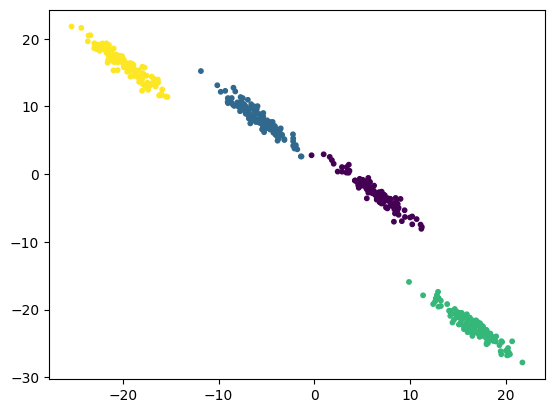

In [7]:
# visualize the ground truth
plt.scatter(X[:,0], X[:,1], s= 10, c=y)

# Clustering

Try different clustering methods

## Standard methods

* Gaussian Mixture Models
* K-Means
* HDBSCAN

In [12]:
# clustering algorithms

def kmeans(X: np.array, n_clusters: int):

    '''Wrapper for sklearn.cluster.KMeans'''

    clusterer = cluster.KMeans(n_clusters=n_clusters)
    
    return clusterer.fit_predict(X)

def gmm(X: np.array, n_clusters: int):

    '''Wrapper for sklearn.mixture.GaussianMixture'''

    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=random_state)

    return clusterer.fit_predict(X)

def hdbscan(X: np.array, n_clusters: int):
    
    '''Wrapper for sklearn.cluster.HDBSCAN'''

    clusterer = cluster.HDBSCAN()

    return clusterer.fit_predict(X)

def agglomerative(X: np.array, n_clusters: int):

    '''Wrapper for sklearn.cluster.AgglomerativeClustering'''

    clusterer = cluster.AgglomerativeClustering(n_clusters=n_clusters)

    return clusterer.fit_predict(X)



CLUSTER_ALGOS = {
    "K-Means": kmeans,
    "Gaussian Mixture Models": gmm,
    "HDBSCAN": hdbscan,
    "Agglomerative Hierarchical": agglomerative
}


## Benchmark Fault Reconstruction Methods
* 

# Cluster validation

There exist a plethora of validation metrics for quantifying the degree of alignment of a cluster assignment with the ground truth. 
In the case where there is ground truth available, these should suffice as a validation metric. 

* Adjusted Rand Index
* Adjusted Mutual Information

In [13]:
# specify all metrics that should be computed
# metric functions must be of the form metric(y_true, y_pred)
METRICS = {
           "Adjusted Rand Index": metrics.adjusted_mutual_info_score,
           "Adjusted Mutual Information": metrics.adjusted_rand_score
           }

def validate_clusters(y_pred: np.array, 
                      y_true: np.array, 
                      metrics: dict = METRICS
                      )->dict:
    '''
    Calculate a range of cluster validation metrics for a given cluster assignment and ground truth

    Parameters
    ------------
    y_pred, y_true: np.array
        The predicted and true labels
    metrics: dict
        The name and function of the metrics to calculate, default = METRICS
        
    Returns
    --------
    metric_vals: dict
        The name and value of the metrics

    '''

    metric_vals = {}

    for name, metric in metrics.items():

        metric_vals[name] = metric(y_true, y_pred)
    
    return metric_vals
    

# Application

Apply the clustering algorithms. In this toy example, we know how many clusters to expect so we can just set the hyperparameter. On real data we would have to employ a validation metric.

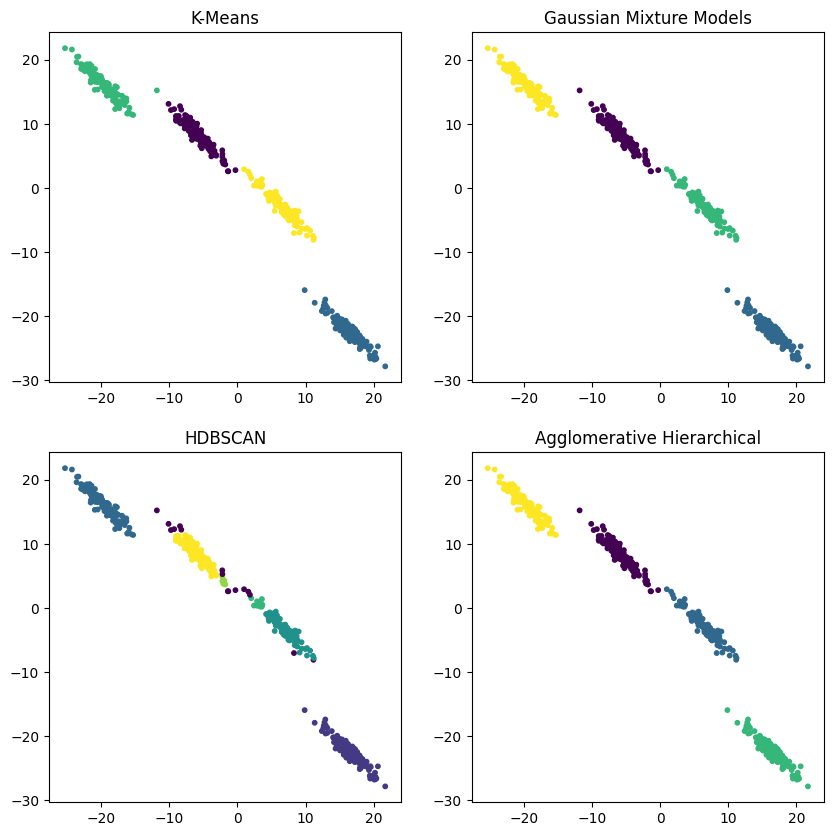

,Adjusted Rand Index,Adjusted Mutual Information
K-Means,0.983078,0.989333
Gaussian Mixture Models,0.991536,0.994656
HDBSCAN,0.913520,0.918141
Agglomerative Hierarchical,0.991536,0.994656


In [15]:
n = 4
cluster_results = {}
val_results = []

fig, ax = plt.subplots(nrows=math.ceil(len(CLUSTER_ALGOS)/2), ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5*math.ceil(len(CLUSTER_ALGOS)/2))
i = 0

for name, algo in CLUSTER_ALGOS.items():

    # get cluster assignment
    y_pred = algo(X,n) 
    
    # visualize results
    ax[i//2,i%2].set_title(name)
    ax[i//2,i%2].scatter(X[:,0], X[:,1], c=y_pred, s=10)

    # validate results
    val_results.append(validate_clusters(y_pred, y))
    
    cluster_results[name] = y_pred
    i += 1

plt.show()

val_results = pd.DataFrame(val_results, index = CLUSTER_ALGOS.keys())
val_results
